# Paper 1: Regularization Effectiveness Study
## Autoren: Katrin Nguyen & Nico Loss

## Import & Setup

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Matplotlib inline for Jupyter Notebooks
%matplotlib inline

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Global variables
CV = 5
LOGSPACE = np.logspace(-4, 1, 30)
MAX_ITER = 10000
SCORING_R2 = "r2"

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Create output directories
output_dirs = ['ReportsV2', 'ModelsV2', 'SaveV2', 'DataV2']
for dir_name in output_dirs:
    Path(dir_name).mkdir(exist_ok=True)

D:\Master KDT\Semester 1\Angew KI\WorkspaceKDT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading
Download Dataset from Kaggle.com: https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices/data

In [2]:
path = kagglehub.dataset_download("nancyalaswad90/diamonds-prices")

print("Path to dataset files:", path)

df = pd.read_csv(path + "/Diamonds Prices2022.csv")

# Remove erroneous index column if present
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

print("Dataset successfully loaded!")

Path to dataset files: C:\Users\nicol\.cache\kagglehub\datasets\nancyalaswad90\diamonds-prices\versions\4
Dataset successfully loaded!


## Train-Validation-Test Split

In [3]:
# Split strategy: 60% train, 20% validation, 20% test
# Stratify by price quartiles to ensure price distribution consistency

# Create price quartiles for stratification
price_quartiles = pd.qcut(df['price'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# First split: separate test set
X_temp = df.drop('price', axis=1)
y_temp = df['price']

X_train_val, X_test_raw, y_train_val, y_test_raw, strat_train_val, strat_test = train_test_split(
    X_temp, y_temp, price_quartiles,
    test_size=0.20,
    random_state=RANDOM_SEED,
    stratify=price_quartiles
)

# Second split: separate train and validation
strat_train_val_reset = pd.Series(strat_train_val.values)
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,  # 0.25 of 0.80 = 0.20 of total
    random_state=RANDOM_SEED,
    stratify=strat_train_val_reset
)

print(f"Split Sizes:")
print(f"  • Training:   {len(X_train_raw):,} samples ({len(X_train_raw)/len(df)*100:.1f}%)")
print(f"  • Validation: {len(X_val_raw):,} samples ({len(X_val_raw)/len(df)*100:.1f}%)")
print(f"  • Test:       {len(X_test_raw):,} samples ({len(X_test_raw)/len(df)*100:.1f}%)")

# Verify price distribution consistency
print("\nPrice Distribution Check:")
print(f"  • Train mean: ${y_train_raw.mean():,.2f} (std: ${y_train_raw.std():,.2f})")
print(f"  • Val mean:   ${y_val_raw.mean():,.2f} (std: ${y_val_raw.std():,.2f})")
print(f"  • Test mean:  ${y_test_raw.mean():,.2f} (std: ${y_test_raw.std():,.2f})")

# Combine X and y for preprocessing
df_train = pd.concat([X_train_raw, y_train_raw], axis=1)
df_val = pd.concat([X_val_raw, y_val_raw], axis=1)
df_test = pd.concat([X_test_raw, y_test_raw], axis=1)

Split Sizes:
  • Training:   32,365 samples (60.0%)
  • Validation: 10,789 samples (20.0%)
  • Test:       10,789 samples (20.0%)

Price Distribution Check:
  • Train mean: $3,924.36 (std: $3,972.47)
  • Val mean:   $3,934.54 (std: $3,993.47)
  • Test mean:  $3,956.05 (std: $4,035.70)


## Automatischer EDA Report

In [4]:
profile = ProfileReport(df_train, title="EDA Diamond Prices", explorative=True)
profile.to_file("Reports/DiamonPrices_EDA_ydata_profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 133.09it/s]


## Data Exploration

In [5]:
print("\nDataset Info:")
print("="*50)
print(df_train.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 32365 entries, 41327 to 512
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    32365 non-null  float64
 1   cut      32365 non-null  object 
 2   color    32365 non-null  object 
 3   clarity  32365 non-null  object 
 4   depth    32365 non-null  float64
 5   table    32365 non-null  float64
 6   x        32365 non-null  float64
 7   y        32365 non-null  float64
 8   z        32365 non-null  float64
 9   price    32365 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 3.7+ MB
None


In [6]:
print("\nFirst 5 rows:")
print("="*50)
print(df_train.head())


First 5 rows:
       carat        cut color clarity  depth  table     x     y     z  price
41327   0.31      Ideal     E      IF   62.5   56.0  4.34  4.37  2.72   1214
41317   0.50  Very Good     G     SI1   62.2   58.0  5.03  5.07  3.14   1214
27591   1.33      Ideal     F      IF   60.2   57.0  7.12  7.17  4.30  18435
13185   1.04  Very Good     G     VS2   61.4   63.0  6.55  6.51  4.01   5451
29696   0.31       Good     G    VVS2   63.1   57.0  4.30  4.32  2.72    707


In [7]:
print("\nStatistical Summary:")
print("="*50)
print(df_train.describe())


Statistical Summary:
              carat         depth         table             x             y  \
count  32365.000000  32365.000000  32365.000000  32365.000000  32365.000000   
mean       0.798037     61.750811     57.463071      5.730952      5.734368   
std        0.473910      1.439140      2.244688      1.121942      1.152130   
min        0.200000     43.000000     43.000000      0.000000      0.000000   
25%        0.400000     61.000000     56.000000      4.710000      4.720000   
50%        0.700000     61.800000     57.000000      5.700000      5.710000   
75%        1.040000     62.500000     59.000000      6.540000      6.540000   
max        5.010000     79.000000     95.000000     10.740000     58.900000   

                  z         price  
count  32365.000000  32365.000000  
mean       3.538950   3924.360297  
std        0.713722   3972.474311  
min        0.000000    326.000000  
25%        2.910000    950.000000  
50%        3.530000   2401.000000  
75%        4.0

In [8]:
print("\nFehlende Werte:")
print("="*50)

print(df_train.isnull().sum().sort_values(ascending=False))


Fehlende Werte:
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64


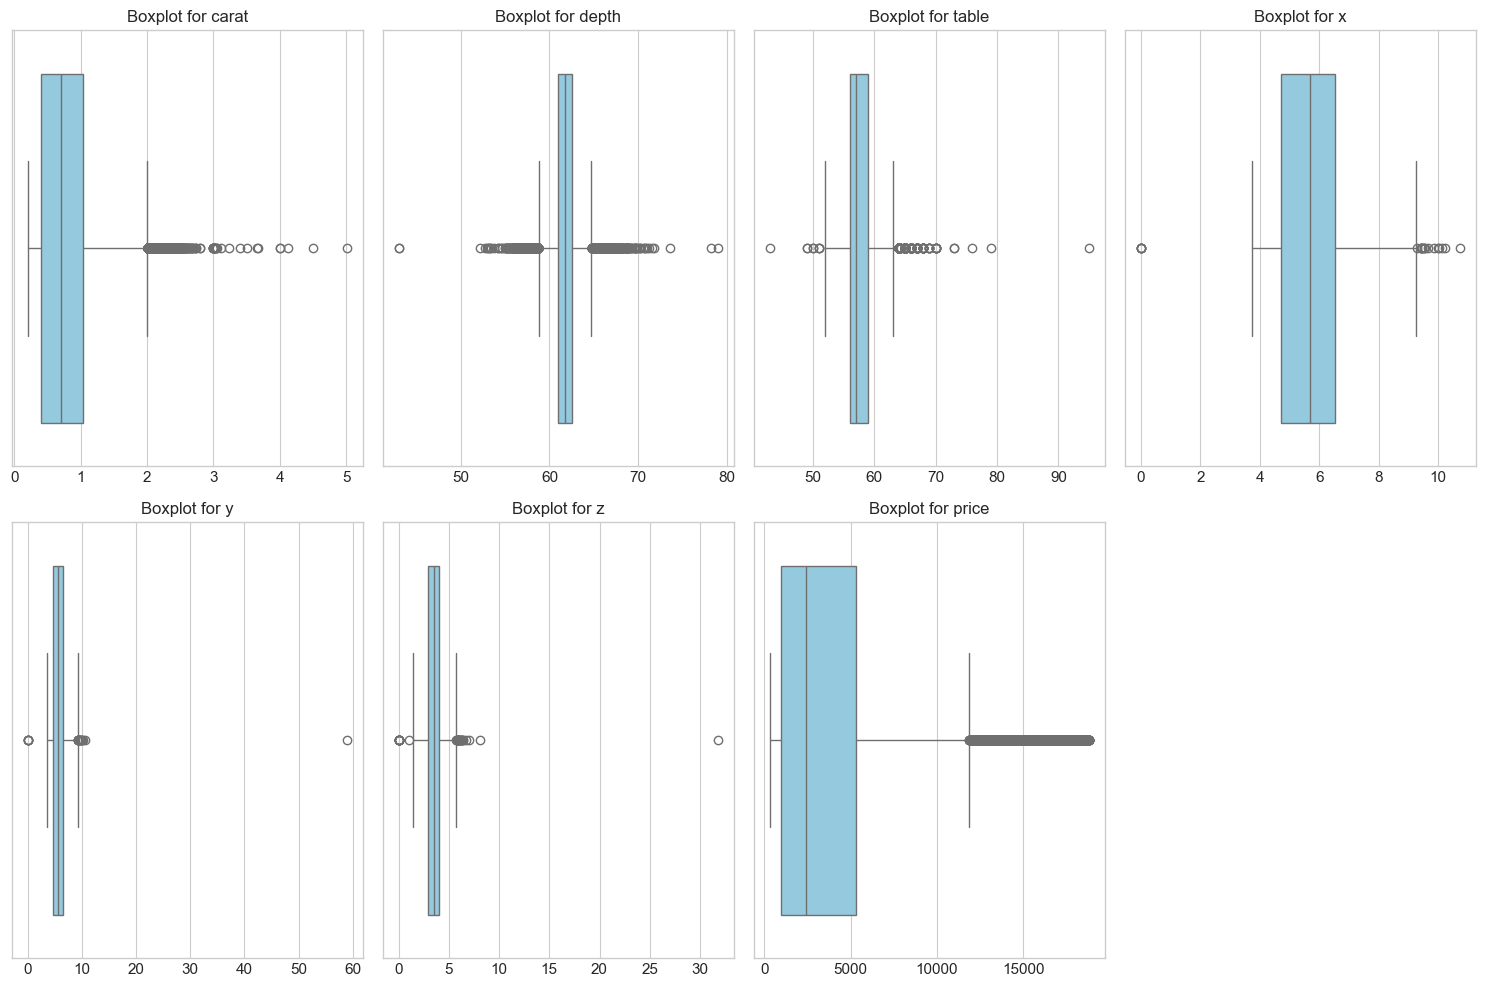

In [9]:
# Numerische Spalten auswählen
numeric_cols = df_train.select_dtypes(include=np.number).columns

# Dynamisch passende Grid-Größe bestimmen
n_cols = 4  # Anzahl der Boxplots pro Zeile
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

# Figure und Subplots erstellen
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Boxplots zeichnen
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df_train[col], ax=axes[i], color="skyblue")
    axes[i].set_title(f"Boxplot for {col}", fontsize=12)
    axes[i].set_xlabel("")

# Leere Subplots ausblenden
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Heatmap der Korrelationen:


<Axes: >

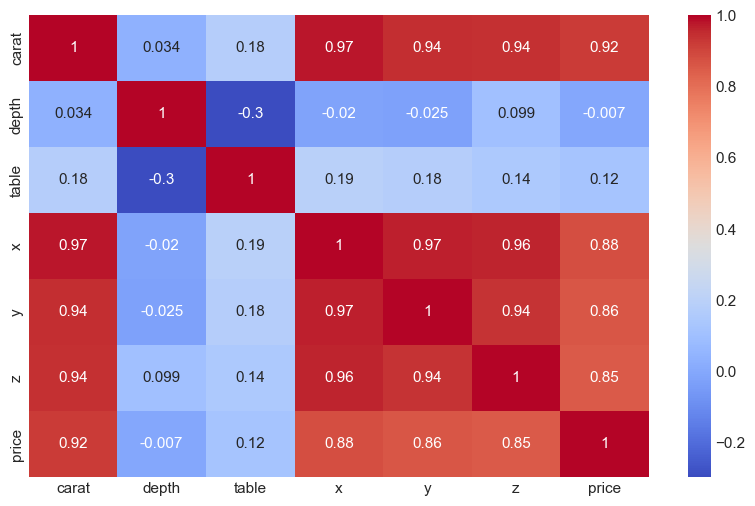

In [10]:
print("\nHeatmap der Korrelationen:")
print("="*50)

corr = df_train.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')

## Automatisches Reporting erstellen

In [11]:
print("\nMultikollinearität prüfen:")
print("="*50)

X = df_train.select_dtypes(include=np.number).drop(columns=['price'])
vif = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
vif


Multikollinearität prüfen:


,Feature,VIF
0,carat,69.169034
1,depth,487.379668
2,table,482.166196
3,x,1092.513331
4,y,415.446355
5,z,371.663614


## Explorative Data Analysis


EXPLORATORY DATA ANALYSIS


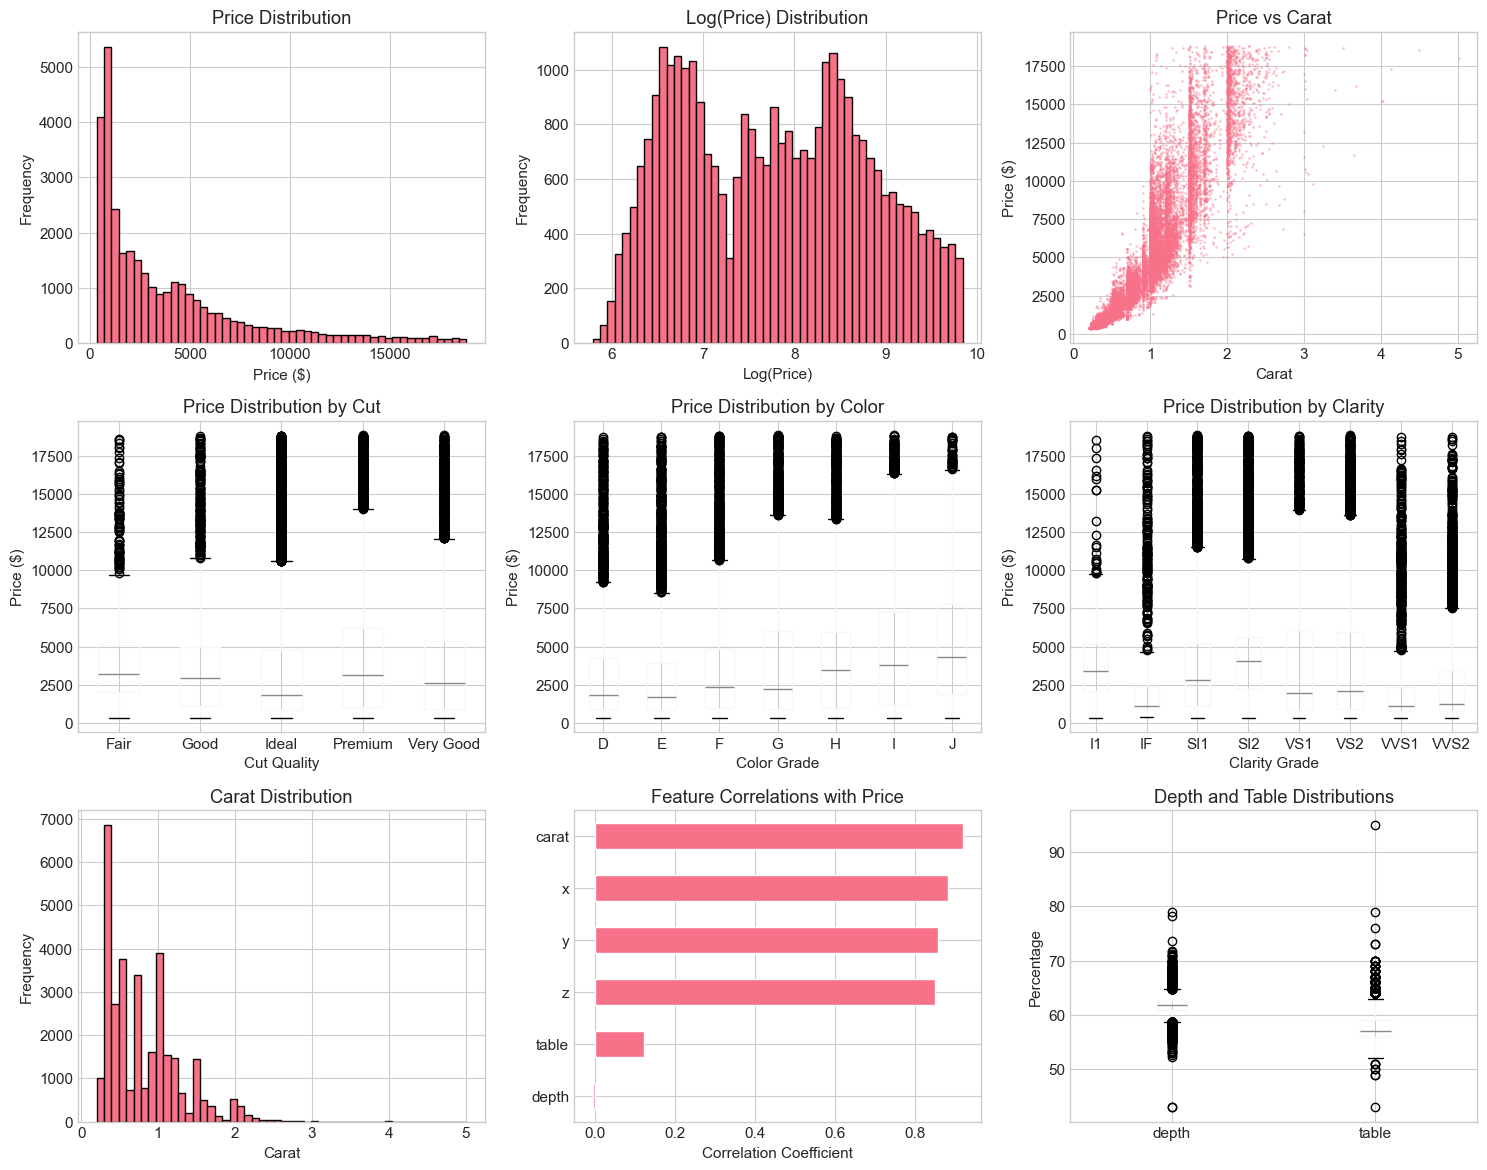

In [12]:
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Create figure for EDA plots
fig = plt.figure(figsize=(15, 12))

# 1. Price distribution
ax1 = plt.subplot(3, 3, 1)
df_train['price'].hist(bins=50, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

# 2. Log-transformed price distribution
ax2 = plt.subplot(3, 3, 2)
np.log1p(df_train['price']).hist(bins=50, edgecolor='black')
plt.title('Log(Price) Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

# 3. Price vs Carat
ax3 = plt.subplot(3, 3, 3)
plt.scatter(df_train['carat'], df_train['price'], alpha=0.3, s=1)
plt.title('Price vs Carat')
plt.xlabel('Carat')
plt.ylabel('Price ($)')

# 4. Price by Cut
ax4 = plt.subplot(3, 3, 4)
df_train.boxplot(column='price', by='cut', ax=ax4)
plt.title('Price Distribution by Cut')
plt.suptitle('')
plt.xlabel('Cut Quality')
plt.ylabel('Price ($)')

# 5. Price by Color
ax5 = plt.subplot(3, 3, 5)
df_train.boxplot(column='price', by='color', ax=ax5)
plt.title('Price Distribution by Color')
plt.suptitle('')
plt.xlabel('Color Grade')
plt.ylabel('Price ($)')

# 6. Price by Clarity
ax6 = plt.subplot(3, 3, 6)
df_train.boxplot(column='price', by='clarity', ax=ax6)
plt.title('Price Distribution by Clarity')
plt.suptitle('')
plt.xlabel('Clarity Grade')
plt.ylabel('Price ($)')

# 7. Carat distribution
ax7 = plt.subplot(3, 3, 7)
df_train['carat'].hist(bins=50, edgecolor='black')
plt.title('Carat Distribution')
plt.xlabel('Carat')
plt.ylabel('Frequency')

# 8. Correlation with price
ax8 = plt.subplot(3, 3, 8)
numeric_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
correlations = df_train[numeric_cols + ['price']].corr()['price'].drop('price').sort_values()
correlations.plot(kind='barh')
plt.title('Feature Correlations with Price')
plt.xlabel('Correlation Coefficient')

# 9. Feature distributions
ax9 = plt.subplot(3, 3, 9)
df_train[['depth', 'table']].boxplot(ax=ax9)
plt.title('Depth and Table Distributions')
plt.ylabel('Percentage')

plt.tight_layout()
plt.savefig('Save/eda_diamonds.png', dpi=300, bbox_inches='tight')
plt.show()